# **Google Colab Notebook for CxC 2025 SAP Challenge**

# Step 1: Import Required Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
import shap
import plotly.express as px
import os

# Step 2: Load Data



In [24]:
data_file = '/content/SAP.xlsx'

# Ensure the file exists
if os.path.exists(data_file):
    xls = pd.ExcelFile(data_file)
    df = pd.read_excel(xls, sheet_name='AFE', engine='openpyxl')
else:
    raise FileNotFoundError("File 'SAP.xlsx' not found in Colab uploads. Please upload it first.")

# Display dataset shape to verify all rows are loaded
print(f"Dataset Loaded with {df.shape[0]} rows and {df.shape[1]} columns.")


Dataset Loaded with 23141 rows and 32 columns.


# Step 3: Select Key Indicators

In [25]:
mpi_indicators = [
    "Literacy rate, youth female (% of females ages 15-24)",
    "Literacy rate, youth (ages 15-24), gender parity index (GPI)",
    "Adjusted savings: education expenditure (current US$)",
    "Access to clean fuels and technologies for cooking (% of population)",
    "Access to electricity (% of population)",
    "Adequacy of social protection and labor programs (% of total welfare of beneficiary households)",
    "Multilateral debt service (% of public and publicly guaranteed debt service)"
]

# Additional indicators for a more comprehensive MPI
additional_indicators = [
    "Life expectancy at birth, total (years)",
    "GINI index (World Bank estimate)",
    "Health expenditure per capita (current US$)",
    "Unemployment, total (% of total labor force)"
]

# Add additional indicators to the list
mpi_indicators.extend(additional_indicators)

# Filter the dataset for selected indicators
mpi_df = df[df["Indicator Name"].isin(mpi_indicators)].copy()
mpi_df = mpi_df.drop(columns=["Topic", "short description", "long description", "Indicator Code", "Unit of measure"])
mpi_df = mpi_df.melt(id_vars=["Country Name", "Country Code", "Indicator Name"], var_name="Year", value_name="Value")
mpi_df["Year"] = mpi_df["Year"].astype(int)
mpi_df = mpi_df.sort_values(by=["Country Name", "Year"])

# Step 4: Handle Missing Values


Missing values before imputation:
Country Name          0
Country Code          0
Indicator Name        0
Year                  0
Value             21725
dtype: int64


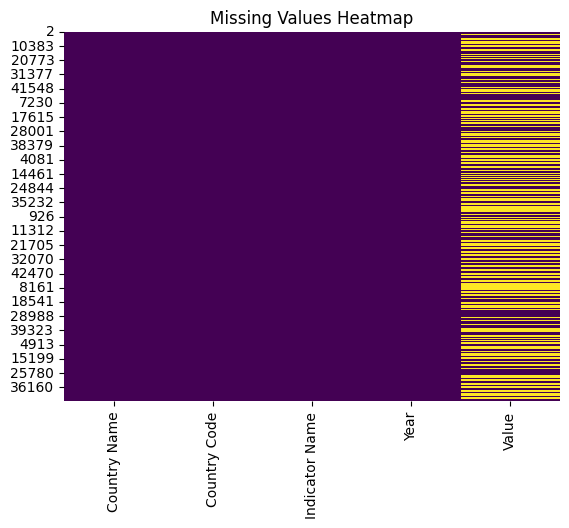

Missing values after imputation:
Country Name      0
Country Code      0
Indicator Name    0
Year              0
Value             0
dtype: int64


In [26]:
print("Missing values before imputation:")
print(mpi_df.isnull().sum())

# Visualize missing values
sns.heatmap(mpi_df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# Use KNN Imputation for missing values
imputer = KNNImputer(n_neighbors=5)
mpi_df['Value'] = imputer.fit_transform(mpi_df[['Value']])

print("Missing values after imputation:")
print(mpi_df.isnull().sum())

# Step 5: Normalize the Data

In [27]:
scaler = MinMaxScaler()
mpi_df['Normalized Value'] = scaler.fit_transform(mpi_df[['Value']])


# Step 6: Perform Feature Selection using PCA

In [28]:
pivot_df = mpi_df.pivot(index=["Country Name", "Year"], columns="Indicator Name", values="Normalized Value").dropna()

# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(pivot_df)
mpi_df_pca = pd.DataFrame(principal_components, index=pivot_df.index, columns=["PC1", "PC2", "PC3"])

# Use explained variance ratio to determine weights
explained_variance = pca.explained_variance_ratio_
weights = explained_variance / explained_variance.sum()
mpi_df_pca["MPI Index"] = (
    mpi_df_pca["PC1"] * weights[0] +
    mpi_df_pca["PC2"] * weights[1] +
    mpi_df_pca["PC3"] * weights[2]
)

# Step 7: Perform Regression Analysis


In [29]:
regressor = LinearRegression()
y = mpi_df_pca["MPI Index"]
X = pivot_df
regressor.fit(X, y)

LinearRegression()

# Step 8: Use Clustering to Find Patterns


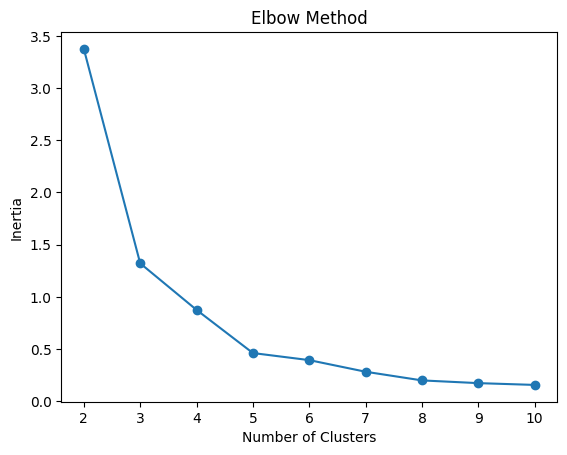

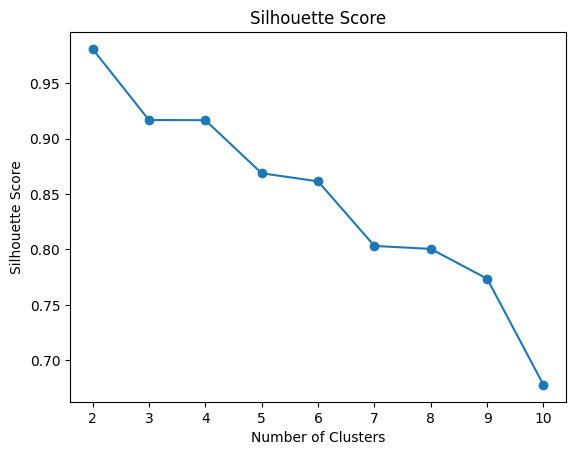

In [30]:
# Elbow Method to determine optimal number of clusters
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(mpi_df_pca[["PC1", "PC2", "PC3"]])
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Silhouette Score to validate the number of clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(mpi_df_pca[["PC1", "PC2", "PC3"]])
    score = silhouette_score(mpi_df_pca[["PC1", "PC2", "PC3"]], kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

# Based on the Elbow Method and Silhouette Score, choose the optimal number of clusters
optimal_clusters = 3  # Adjust based on the plots
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
mpi_df_pca["Cluster"] = kmeans.fit_predict(mpi_df_pca[["PC1", "PC2", "PC3"]])


# Step 9: Generate Insights and Policy Recommendations

In [31]:
# Identify countries in the worst cluster
worst_cluster = mpi_df_pca[mpi_df_pca["Cluster"] == mpi_df_pca["Cluster"].min()]
print("Countries in the worst cluster:")
print(worst_cluster.index.get_level_values("Country Name").unique())

# Feature Importance using RandomForest
feature_importance_model = RandomForestRegressor()
feature_importance_model.fit(X, y)
importances = feature_importance_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print("Top 3 important indicators:")
print(feature_importance_df.head(3))

Countries in the worst cluster:
Index(['Afghanistan', 'Africa Eastern and Southern',
       'Africa Western and Central', 'Albania', 'Algeria', 'American Samoa',
       'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World',
       ...
       'Uzbekistan', 'Vanuatu', 'Venezuela, RB', 'Viet Nam',
       'Virgin Islands (U.S.)', 'West Bank and Gaza', 'World', 'Yemen, Rep.',
       'Zambia', 'Zimbabwe'],
      dtype='object', name='Country Name', length=266)
Top 3 important indicators:
                                             Feature  Importance
3  Adjusted savings: education expenditure (curre...    0.999784
6  Multilateral debt service (% of public and pub...    0.000146
0  Access to clean fuels and technologies for coo...    0.000058


# Step 10: Visualize Results

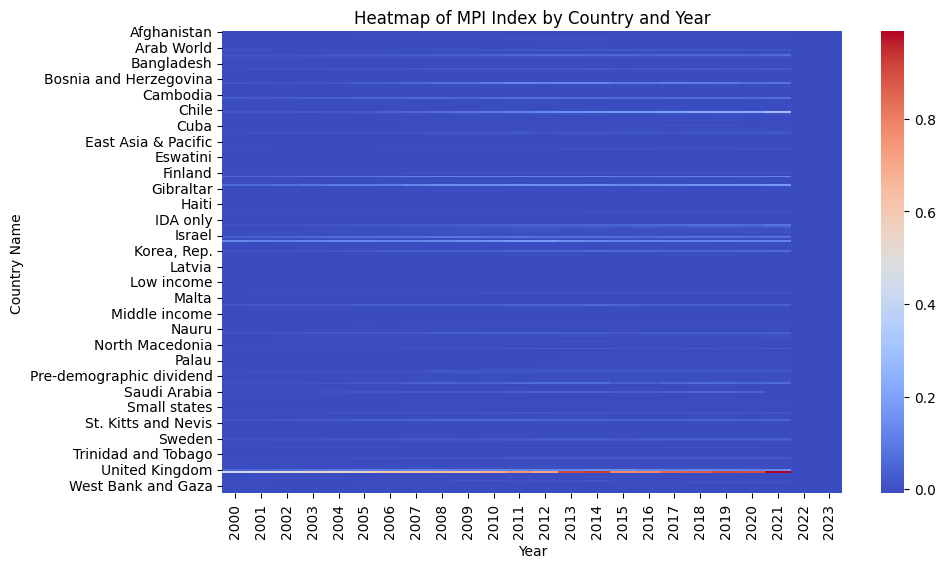

In [32]:
# Heatmap of MPI Index by Country and Year
plt.figure(figsize=(10, 6))
sns.heatmap(mpi_df_pca.pivot_table(index="Country Name", columns="Year", values="MPI Index"), cmap="coolwarm")
plt.title("Heatmap of MPI Index by Country and Year")
plt.show()

# Interactive 3D Scatter Plot of PCA Components
fig = px.scatter_3d(mpi_df_pca, x="PC1", y="PC2", z="PC3", color="Cluster",
                    hover_name=mpi_df_pca.index.get_level_values("Country Name"))
fig.update_layout(title="3D Scatter Plot of PCA Components")
fig.show()